# Sarter Notebook

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Reading Data

In [2]:
# read train data
df_orders = pd.read_csv("orders.csv", sep=";")
df_products = pd.read_csv("product_attributes.csv", sep=",")
df_dists = pd.read_csv("cities_data.csv", sep=";")

# read test data
df_test = pd.read_csv("test.csv", sep=";")

In [3]:
def preprocess(df_orders, df_products, df_dists, material_handling=5.0, weight=1200, late_order=True):

    #replace inconsistent port names
    df_orders.loc[df_orders['origin_port'] == 'ATHENAS', ['origin_port']] = 'Athens'
    df_orders.loc[df_orders['origin_port'] == 'BCN', ['origin_port']] = 'Barcelona'
    df_orders.loc[df_orders['customer'] == 'ATHENAS', ['customer']] = 'Athens'
    df_orders.loc[df_orders['customer'] == 'BCN', ['customer']] = 'Barcelona'
    df_orders.loc[df_orders['logistic_hub'] == 'ATHENAS', ['logistic_hub']] = 'Athens'
    df_orders.loc[df_orders['logistic_hub'] == 'BCN', ['logistic_hub']] = 'Barcelona'

    #add reverse paths and trivial paths to cities
    cities_unique_from = df_dists[['city_from_name', 'city_from_coord']].drop_duplicates()
    cities_unique_to = cities_unique_from.rename(columns={'city_from_name': 'city_to_name', 'city_from_coord': 'city_to_coord'})
    cities_id = pd.concat([cities_unique_from, cities_unique_to], axis=1)
    cities_id['distance'] = 0
    cities_reverse = df_dists.rename(columns={'city_from_name': 'city_to_name', 'city_from_coord': 'city_to_coord',
                                              'city_to_name': 'city_from_name', 'city_to_coord': 'city_from_coord'})
    cities_final = pd.concat([cities_id, cities_reverse, df_dists])

    #deal with null logistic hubs
    df_orders.loc[df_orders['logistic_hub'].isnull(),'logistic_hub'] = df_orders['origin_port']

    #finally join cities data
    cities_joined_first_trip = pd.merge(df_orders, cities_final, how='left', left_on=['origin_port', 'logistic_hub'], right_on=['city_from_name', 'city_to_name'])

    cities_joined_first_trip_renamed = cities_joined_first_trip.rename(columns={'distance': 'distance_1', 'city_to_coord': 'logistic_hub_coord',
                                                                                'city_from_coord': 'origin_port_coord'})


    cities_joined_second_trip = pd.merge(cities_joined_first_trip_renamed, cities_final,  how='left', left_on=['logistic_hub', 'customer'], right_on=['city_from_name', 'city_to_name'])

    cities_joined_second_trip_renamed = cities_joined_second_trip.rename(columns={'distance': 'distance_2', 'city_to_coord': 'customer_coord'})

    #join with product data
    product_atts_joined = pd.merge(cities_joined_second_trip_renamed, df_products, how='left')

    #fill empty cells
    product_atts_joined.loc[product_atts_joined['material_handling'].isna(), 'material_handling'] = material_handling
    product_atts_joined.loc[product_atts_joined['weight'].isna(), 'weight'] = weight
    final = product_atts_joined#.dropna()

    assert final.shape[0] == df_orders.shape[0]

    columns = ['3pl', 'customs_procedures','material_handling', 'units', 'weight', 'product_id',
                                  'origin_port', 'origin_port_coord',
                                  'logistic_hub', 'logistic_hub_coord',
                                  'customer', 'customer_coord',
                                  'distance_1', 'distance_2']
    if late_order:
        columns.append('late_order')

    return final[columns]



In [4]:
# get all the training data
xy_train = preprocess(df_orders, df_products, df_dists, late_order=True)
x_test = preprocess(df_test, df_products, df_dists, late_order=False)

y_train = xy_train['late_order']
x_train = xy_train.drop('late_order', axis=1)
xy_train

,3pl,customs_procedures,material_handling,units,weight,product_id,origin_port,origin_port_coord,logistic_hub,logistic_hub_coord,customer,customer_coord,distance_1,distance_2,late_order
0,v_002,DTP,5.0,583,1778.0,1692723,Rotterdam,"(51.9244424, 4.47775)",Venlo,"(51.39244885, 6.1511724144122955)",Marseille,"(43.2961743, 5.3699525)",130.0459,902.0420,True
1,v_004,CRF,3.0,459,1088.0,1644308,Rotterdam,"(51.9244424, 4.47775)",Rome,"(41.8933203, 12.4829321)",Marseille,"(43.2961743, 5.3699525)",1269.2365,604.0216,False
2,v_002,CRF,4.0,464,505.0,1684170,Athens,"(37.9839412, 23.7283052)",Venlo,"(51.39244885, 6.1511724144122955)",Paris,"(48.8588897, 2.3200410217200766)",2029.5726,392.9249,True
3,v_004,CRF,4.0,678,1308.0,1620510,Rotterdam,"(51.9244424, 4.47775)",Lille,"(50.6365654, 3.0635282)",Milan,"(45.4641943, 9.1896346)",173.9644,733.8784,False
4,v_002,CRF,0.0,353,1465.0,1699372,Barcelona,"(41.3828939, 2.1774322)",Venlo,"(51.39244885, 6.1511724144122955)",Berlin,"(52.5170365, 13.3888599)",1153.4178,512.8188,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114271,v_002,CRF,3.0,645,1896.0,1681376,Rotterdam,"(51.9244424, 4.47775)",Dusseldorf,"(51.2254018, 6.7763137)",Bordeaux,"(44.841225, -0.5800364)",177.3075,896.2065,False
114272,v_004,DTD,1.0,502,746.0,1676942,Barcelona,"(41.3828939, 2.1774322)",Dusseldorf,"(51.2254018, 6.7763137)",Berlin,"(52.5170365, 13.3888599)",1149.4065,477.3717,False
114273,v_002,DTP,5.0,464,572.0,1692737,Rotterdam,"(51.9244424, 4.47775)",Dusseldorf,"(51.2254018, 6.7763137)",Rome,"(41.8933203, 12.4829321)",177.3075,1125.0290,False
114274,v_003,DTD,1.0,388,1894.0,1699974,Barcelona,"(41.3828939, 2.1774322)",Dusseldorf,"(51.2254018, 6.7763137)",Munich,"(48.1371079, 11.5753822)",1149.4065,487.5926,False


In [6]:
from catboost import CatBoostClassifier

# adjust data for catboost classifier
x_train['material_handling'] = x_train['material_handling'].astype(str)
x_train = x_train.drop(columns=['origin_port_coord', 'logistic_hub_coord', 'customer_coord'])
x_test['material_handling'] = x_test['material_handling'].astype(str)
x_test = x_test.drop(columns=['origin_port_coord', 'logistic_hub_coord', 'customer_coord'])

#choose categorical features
cat_features = ['3pl', 'customs_procedures', 'material_handling', 'origin_port', 'logistic_hub', 'customer', 'product_id']
model = CatBoostClassifier(iterations=200,
                           learning_rate=0.1,
                           depth=3)

#train the model
model.fit(x_train, y_train, cat_features)

#predict on the test data
preds_proba = model.predict_proba(x_test)

0:	learn: 0.6517574	total: 577ms	remaining: 1m 54s
1:	learn: 0.6184582	total: 822ms	remaining: 1m 21s
2:	learn: 0.5935095	total: 888ms	remaining: 58.3s
3:	learn: 0.5721981	total: 943ms	remaining: 46.2s
4:	learn: 0.5553361	total: 998ms	remaining: 38.9s
5:	learn: 0.5415364	total: 1.06s	remaining: 34.2s
6:	learn: 0.5295341	total: 1.12s	remaining: 30.9s
7:	learn: 0.5149150	total: 1.17s	remaining: 28s
8:	learn: 0.5026073	total: 1.22s	remaining: 25.9s
9:	learn: 0.4922004	total: 1.27s	remaining: 24.1s
10:	learn: 0.4845011	total: 1.32s	remaining: 22.6s
11:	learn: 0.4779190	total: 1.37s	remaining: 21.5s
12:	learn: 0.4724912	total: 1.42s	remaining: 20.4s
13:	learn: 0.4677555	total: 1.47s	remaining: 19.5s
14:	learn: 0.4631552	total: 1.53s	remaining: 18.9s
15:	learn: 0.4590513	total: 1.58s	remaining: 18.2s
16:	learn: 0.4554857	total: 1.62s	remaining: 17.5s
17:	learn: 0.4528694	total: 1.67s	remaining: 16.9s
18:	learn: 0.4505513	total: 1.72s	remaining: 16.4s
19:	learn: 0.4480265	total: 1.76s	remaini

In [9]:
preds_proba

array([[0.93691633, 0.06308367],
       [0.90126979, 0.09873021],
       [0.7227818 , 0.2772182 ],
       ...,
       [0.92446981, 0.07553019],
       [0.5272059 , 0.4727941 ],
       [0.734033  , 0.265967  ]])

In [7]:
# Save predictions to CSV
submission = pd.DataFrame({"order_id": df_test.order_id, "late_order": preds_proba[:,1]})
submission.to_csv("final.csv", index=False)

In [17]:
importances = model.get_feature_importance()

In [19]:
print(x_train.head())

     3pl customs_procedures material_handling  units  weight  product_id  \
0  v_002                DTP               5.0    583  1778.0     1692723   
1  v_004                CRF               3.0    459  1088.0     1644308   
2  v_002                CRF               4.0    464   505.0     1684170   
3  v_004                CRF               4.0    678  1308.0     1620510   
4  v_002                CRF               0.0    353  1465.0     1699372   

  origin_port logistic_hub   customer  distance_1  distance_2  
0   Rotterdam        Venlo  Marseille    130.0459    902.0420  
1   Rotterdam         Rome  Marseille   1269.2365    604.0216  
2      Athens        Venlo      Paris   2029.5726    392.9249  
3   Rotterdam        Lille      Milan    173.9644    733.8784  
4   Barcelona        Venlo     Berlin   1153.4178    512.8188  


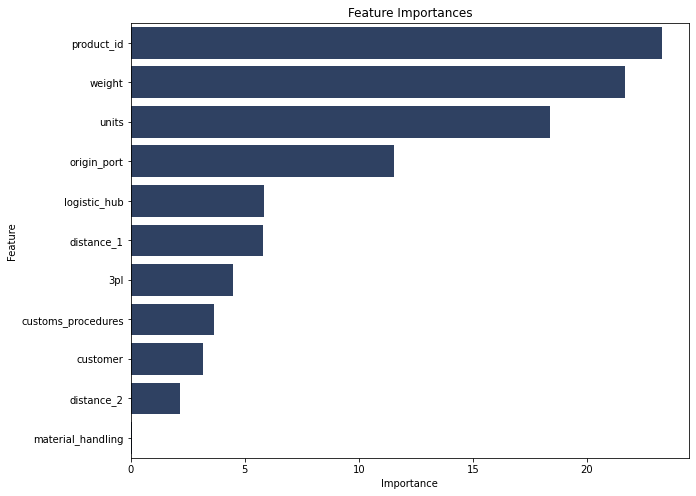

In [33]:
feature_dict = {'Feature': list(x_train), 'Importance': importances}
df_features = pd.DataFrame(feature_dict)
df_features = df_features.sort_values(by=['Importance'], ascending=False)
plt.figure(figsize=(10, 8))
sns.barplot(y=df_features['Feature'], x=df_features['Importance'], color='#263f6b')
plt.title('Feature Importances')
plt.savefig("./importances.png")
plt.show()

In [23]:
df_features

,Feature,Importance
0,3pl,4.459360
1,customs_procedures,3.633896
2,material_handling,0.064845
3,units,18.365711
4,weight,21.671056
5,product_id,23.301207
6,origin_port,11.542335
7,logistic_hub,5.822244
8,customer,3.181712
9,distance_1,5.811999
